In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import bokeh.layouts as bkl
import bokeh.plotting as bk
from bokeh.io import output_notebook

from lcc.plotting import export_png

output_notebook()

Loading BokehJS ...

# Data loading

In [3]:
from pathlib import Path

SWEEP_PATH = Path("out") / "sweep"
BASELINES_PATH = Path("out") / "baselines"

In [4]:
HF_MODEL_NAME = "microsoft/resnet-18"
VERSION = "cd94cb4c200146e292706f83b8fce717"

MODEL = HF_MODEL_NAME.replace("/", "-")

DATASET = "cifar100"
TRAIN_SPLIT = "train[:80%]"
VAL_SPLIT = "train[80%:]"
TEST_SPLIT = "test"
IMAGE_KEY = "img"
LABEL_KEY = "fine_label"

In [18]:
import json

result_file_path = Path("out/sweep") / DATASET / MODEL / f"results.{VERSION}.json"
with result_file_path.open("r", encoding="utf-8") as fp:
    result = json.load(fp)

ckpt_path = SWEEP_PATH / result["training"]["best_checkpoint"]["path"]

print("Checkpoint path:", ckpt_path)
result

Checkpoint path: out/sweep/cifar100/microsoft-resnet-18/tb_logs/microsoft-resnet-18/cd94cb4c200146e292706f83b8fce717/checkpoints/epoch=47-step=3792.ckpt


{'__meta__': {'version': 3,
  'hostname': 'kusatsu',
  'datetime': {'__type__': 'datetime.datetime',
   '__version__': 1,
   'datetime': '2024-11-27T19:44:19.140175'},
  'hash': '3a0791fa3a0c92abd1a3be647ef01fc9a3d3dccb'},
 'dataset': {'name': 'cifar100',
  'n_classes': 100,
  'train_split': 'train[:80%]',
  'val_split': 'train[80%:]',
  'test_split': 'test',
  'image_key': 'img',
  'label_key': 'fine_label',
  'batch_size': 256},
 'model': {'name': 'microsoft/resnet-18',
  'hparams': {'n_classes': 100,
   'head_name': 'classifier.1',
   'logit_key': 'logits',
   'image_key': 'img',
   'label_key': 'fine_label',
   'lcc_submodules': ['resnet.encoder.stages.3'],
   'lcc_kwargs': {'interval': 1, 'k': 50, 'warmup': 1, 'weight': 0.01},
   'ce_weight': 1.0,
   'model_name': 'microsoft/resnet-18'}},
 'training': {'best_checkpoint': {'path': 'cifar100/microsoft-resnet-18/tb_logs/microsoft-resnet-18/cd94cb4c200146e292706f83b8fce717/checkpoints/epoch=47-step=3792.ckpt',
   'version': 'cd94cb4c2

In [6]:
from lcc.datasets import HuggingFaceDataset
from lcc.classifiers import TimmClassifier, HuggingFaceClassifier

Classifier = (
    TimmClassifier if HF_MODEL_NAME.startswith("timm/") else HuggingFaceClassifier
)

dl_kw = {"batch_size": 256, "num_workers": 1}
ds = HuggingFaceDataset(
    dataset_name=DATASET,
    fit_split=TRAIN_SPLIT,
    val_split=VAL_SPLIT,
    test_split=TEST_SPLIT,
    label_key=LABEL_KEY,
    image_processor=Classifier.get_image_processor(HF_MODEL_NAME),
    train_dl_kwargs=dl_kw,
    val_dl_kwargs=dl_kw,
)
ds.setup("fit")

In [7]:
def load_version(sweep_dir: Path, version: int):
    result_file_path = sweep_dir / DATASET / MODEL / f"results.{version}.json"
    with result_file_path.open("r", encoding="utf-8") as fp:
        result = json.load(fp)
    ckpt_path = sweep_dir / result["training"]["best_checkpoint"]["path"]
    model = Classifier.load_from_checkpoint(ckpt_path)
    print("Loaded version", version, ":", ckpt_path)
    print("Hyperparameters")
    print(model.hparams)
    return model

In [8]:
baseline, model = load_version(BASELINES_PATH, 0), load_version(SWEEP_PATH, VERSION)

Loaded version 0 : out/baselines/cifar100/microsoft-resnet-18/tb_logs/microsoft-resnet-18/version_0/checkpoints/epoch=7-step=320.ckpt
Hyperparameters
"ce_weight":      1.0
"head_name":      classifier.1
"image_key":      img
"label_key":      fine_label
"lcc_kwargs":     None
"lcc_submodules": None
"logit_key":      logits
"model_name":     microsoft/resnet-18
"n_classes":      100
Loaded version cd94cb4c200146e292706f83b8fce717 : out/sweep/cifar100/microsoft-resnet-18/tb_logs/microsoft-resnet-18/cd94cb4c200146e292706f83b8fce717/checkpoints/epoch=47-step=3792.ckpt
Hyperparameters
"ce_weight":      1.0
"head_name":      classifier.1
"image_key":      img
"label_key":      fine_label
"lcc_kwargs":     {'interval': 1, 'k': 50, 'warmup': 1, 'weight': 0.01}
"lcc_submodules": ['resnet.encoder.stages.3']
"logit_key":      logits
"model_name":     microsoft/resnet-18
"n_classes":      100


In [9]:
baseline.hparams

"ce_weight":      1.0
"head_name":      classifier.1
"image_key":      img
"label_key":      fine_label
"lcc_kwargs":     None
"lcc_submodules": None
"logit_key":      logits
"model_name":     microsoft/resnet-18
"n_classes":      100

# Compute latent representations & data

In [10]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import torch

# SUBMODULE = "model.layer4"
SUBMODULE = "model.classifier.1"
# SUBMODULE = "model.resnet.encoder.stages.3"

_z_bl, _z_ft = [], []

for batch in tqdm(ds.train_dataloader()):
    out = {}
    baseline.forward_intermediate(batch, [SUBMODULE], out)
    _z_bl.append(out[SUBMODULE].flatten(1))
    out = {}
    model.forward_intermediate(batch, [SUBMODULE], out)
    _z_ft.append(out[SUBMODULE].flatten(1))

z_bl, z_ft = torch.cat(_z_bl), torch.cat(_z_ft)
z_bl, z_ft = StandardScaler().fit_transform(z_bl), StandardScaler().fit_transform(z_ft)
z_bl, z_ft = torch.tensor(z_bl), torch.tensor(z_ft)
z_bl.shape, z_ft.shape

  0%|          | 0/157 [00:00<?, ?it/s]

(torch.Size([40000, 100]), torch.Size([40000, 100]))

In [16]:
from tempfile import TemporaryDirectory

import torch

from lcc.correction import louvain_communities
from lcc.datasets import BatchedTensorDataset

K = model.hparams["lcc_kwargs"]["k"]
print("k =", K)

with TemporaryDirectory() as tmp:
    BatchedTensorDataset.save(z_bl, tmp, prefix="bl")
    BatchedTensorDataset.save(z_ft, tmp, prefix="ft")
    ds_bl = BatchedTensorDataset(tmp, prefix="bl")
    ds_ft = BatchedTensorDataset(tmp, prefix="ft")
    _, y_clst_bl = louvain_communities(ds_bl, k=K, tqdm_style="notebook")
    _, y_clst_ft = louvain_communities(ds_ft, k=K, tqdm_style="notebook")

2024-12-05 15:35:29.236 | WARNING  | lcc.logging:r0_warning:75 - Passed a strategy object to knn_graph, but strategy is not parallel. Falling back to non-distributed implementation.


k = 50


[Rank 0/1] Building KNN index (k=50):   0%|          | 0/157 [00:00<?, ?it/s]

[Rank 0/1] Building KNN graph (k=50):   0%|          | 0/157 [00:00<?, ?it/s]

2024-12-05 15:36:04.135 | WARNING  | lcc.logging:r0_warning:75 - Passed a strategy object to knn_graph, but strategy is not parallel. Falling back to non-distributed implementation.


[Rank 0/1] Building KNN index (k=50):   0%|          | 0/157 [00:00<?, ?it/s]

[Rank 0/1] Building KNN graph (k=50):   0%|          | 0/157 [00:00<?, ?it/s]

In [17]:
from lcc.correction import class_otm_matching, otm_matching_predicates
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

y_true = ds.y_true("train")

matching_bl = class_otm_matching(y_true, y_clst_bl)
matching_ft = class_otm_matching(y_true, y_clst_ft)

data = []
for i_true in tqdm(np.unique(y_true)):
    clsts_bl, clsts_ft = matching_bl[i_true], matching_ft[i_true]
    p1, p2, _, _ = otm_matching_predicates(y_true, y_clst_bl, matching_bl)
    p_cc_bl = (p1 & p2).sum(axis=0).astype(bool)
    p1, p2, _, _ = otm_matching_predicates(y_true, y_clst_ft, matching_ft)
    p_cc_ft = (p1 & p2).sum(axis=0).astype(bool)
    n_smpl_bl = np.sum(
        [len(z_bl[y_clst_bl == i_clst]) for i_clst in matching_bl[i_true]]
    )
    n_smpl_ft = np.sum(
        [len(z_ft[y_clst_ft == i_clst]) for i_clst in matching_ft[i_true]]
    )
    n_cc_bl = np.sum(
        [p_cc_bl[y_clst_bl == i_clst].sum() for i_clst in matching_bl[i_true]]
    )
    n_cc_ft = np.sum(
        [p_cc_ft[y_clst_ft == i_clst].sum() for i_clst in matching_ft[i_true]]
    )
    data.append(
        {
            "i_true": i_true,
            "n_clst_bl": len(clsts_bl),
            "n_clst_ft": len(clsts_ft),
            "n_smpl_bl": n_smpl_bl,
            "n_smpl_ft": n_smpl_ft,
            "n_cc_bl": n_cc_bl,
            "n_cc_ft": n_cc_ft,
        }
    )

df = pd.DataFrame(data)
df = df.astype({c: int for c in df.columns if c.startswith("n_")})

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
from IPython.display import display

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(df[(df["n_clst_bl"] > 0) & (df["n_clst_ft"] > 0)])

,i_true,n_clst_bl,n_clst_ft,n_smpl_bl,n_smpl_ft,n_cc_bl,n_cc_ft
0,0,1,1,793,396,397,396
1,1,1,1,777,389,386,387
2,2,1,1,1601,400,402,400
6,6,1,1,1187,399,404,399
8,8,1,1,821,423,423,422
14,14,1,1,411,417,411,415
16,16,1,1,810,414,412,413
17,17,1,1,798,408,408,408
18,18,1,1,415,416,412,413
19,19,1,1,809,416,416,416


# Basic cluster statistics plots

In [20]:
from pathlib import Path

OUTPUT_DIR = SWEEP_PATH / "analysis" / DATASET / MODEL / str(VERSION)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [21]:
import seaborn as sns

NICE_NAMES = {
    "i_true": "True label",
    "n_clst_bl": "Nb. of matched clsts. (baseline)",
    "n_clst_ft": "Nb. of matched clsts. (after LCC)",
    "n_smpl_bl": "Nb. of matched smpls (baseline)",
    "n_smpl_ft": "Nb. of matched smpls (after LCC)",
    "n_cc_bl": "Nb. of CC smpls (baseline)",
    "n_cc_ft": "Nb. of CC smpls (after LCC)",
}

<Axes: title={'center': 'Number of matched clusters to true labels'}, ylabel='Number of matched clusters'>

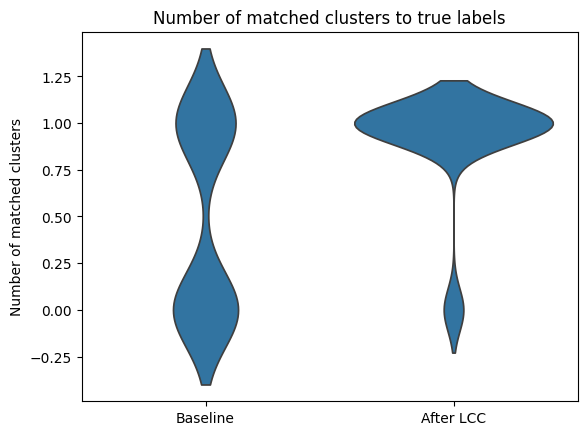

In [22]:
_df = df  # [(df["n_clst_bl"] > 0) & (df["n_clst_ft"] > 0)]
_df = _df[["i_true", "n_clst_bl", "n_clst_ft"]]
_df = _df.rename({"n_clst_bl": "Baseline", "n_clst_ft": "After LCC"}, axis=1)
_df = _df.melt(id_vars="i_true", var_name="", value_name="Number of matched clusters")

title = "Number of matched clusters to true labels"
figure = sns.violinplot(data=_df, x="", y="Number of matched clusters", inner=None)
figure.set(title=title)
figure.get_figure().savefig(OUTPUT_DIR / "n_clst.png")
figure

<Axes: title={'center': 'Number of matched samples to true labels'}, ylabel='Number of matched samples'>

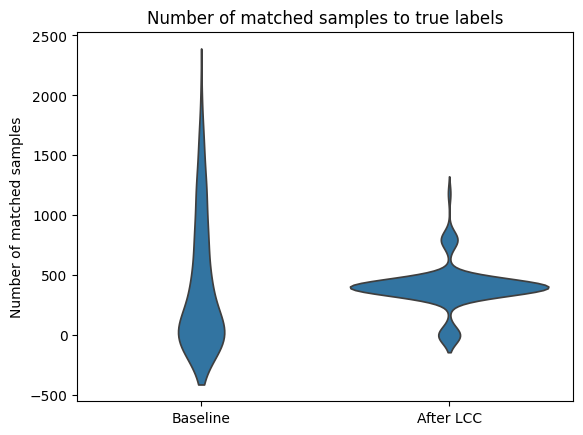

In [23]:
_df = df  # [(df["n_clst_bl"] > 0) & (df["n_clst_ft"] > 0)]
_df = _df[["i_true", "n_smpl_bl", "n_smpl_ft"]]
_df = _df.rename({"n_smpl_bl": "Baseline", "n_smpl_ft": "After LCC"}, axis=1)
_df = _df.melt(id_vars="i_true", var_name="", value_name="Number of matched samples")

title = "Number of matched samples to true labels"
figure = sns.violinplot(data=_df, x="", y="Number of matched samples", inner=None)
figure.set(title=title)
figure.get_figure().savefig(OUTPUT_DIR / "n_smpl.png")
figure

<Axes: title={'center': 'Number of correctly clustered samples per true labels'}, ylabel='Number of correctly clustered samples'>

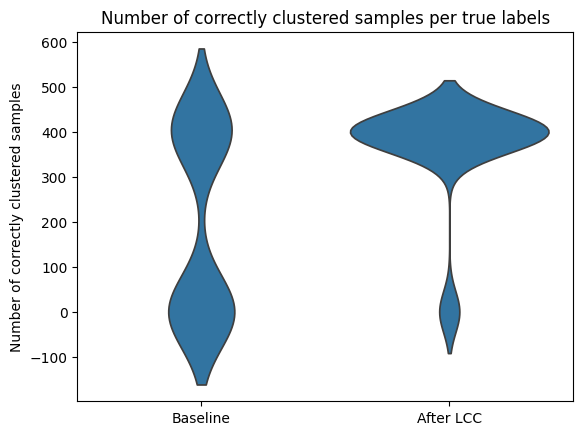

In [24]:
_df = df  # [(df["n_clst_bl"] > 0) & (df["n_clst_ft"] > 0)]
_df = _df[["i_true", "n_cc_bl", "n_cc_ft"]]
_df = _df.rename({"n_cc_bl": "Baseline", "n_cc_ft": "After LCC"}, axis=1)
_df = _df.melt(
    id_vars="i_true", var_name="", value_name="Number of correctly clustered samples"
)

title = "Number of correctly clustered samples per true labels"
figure = sns.violinplot(
    data=_df, x="", y="Number of correctly clustered samples", inner=None
)
figure.set(title=title)
figure.get_figure().savefig(OUTPUT_DIR / "n_cc_smpl.png")
figure

# Distance distribution plots

## Single class

In [25]:
import bokeh.plotting as bk
from bokeh.models import Range1d
from lcc.analysis import distance_distribution, distance_distribution_plot
import torch

i_true = 49
row = df[df["i_true"] == i_true].iloc[0]

data = []

for i_clst in matching_bl[i_true]:
    d = torch.pdist(z_bl[y_clst_bl == i_clst])
    _df = pd.DataFrame({"Distance": d})
    _df["Model"] = "Baseline"
    data.append(_df)

for i_clst in matching_ft[i_true]:
    d = torch.pdist(z_ft[y_clst_ft == i_clst])
    _df = pd.DataFrame({"Distance": d})
    _df["Model"] = "After LCC"
    data.append(_df)

dd_df = pd.concat(data)
print(len(dd_df), "rows")

162006 rows


[Text(0.5, 1.0, "[i_true=49] Distance distribution of matched clsts. in \n• baseline model (n_clst=1, n_smpl=403)\n• LCC'd model (n_clst=1, n_smpl=403) ")]

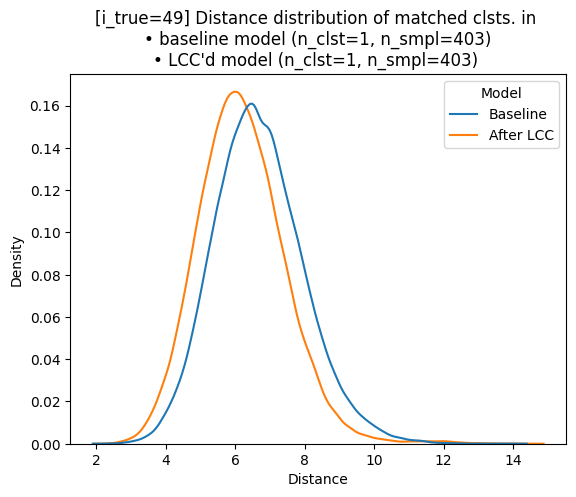

In [26]:
import seaborn as sns

title = (
    f"[i_true={i_true}] "
    f"Distance distribution of matched clsts. in \n"
    f"• baseline model (n_clst={row['n_clst_bl']}, n_smpl={row['n_smpl_bl']})\n"
    f"• LCC'd model (n_clst={row['n_clst_ft']}, n_smpl={row['n_smpl_ft']}) "
)

figure = sns.kdeplot(data=dd_df, x="Distance", hue="Model")
figure.set(title=title)

## Multiple classes

In [27]:
import bokeh.plotting as bk
from bokeh.models import Range1d
from lcc.analysis import distance_distribution, distance_distribution_plot
import torch
from tqdm.notebook import tqdm

_df = df.copy()
_df = _df[(_df["n_clst_bl"] > 0) & (_df["n_clst_ft"] > 0)]
_df["m"] = np.abs(_df["n_smpl_bl"] - _df["n_smpl_ft"])
_df = _df.sort_values("i_true", ascending=True)
_df = _df.head(5)

data = []
for _, row in tqdm(list(_df.iterrows())):
    i_true = row["i_true"]
    for i_clst in matching_bl[i_true]:
        d = torch.pdist(z_bl[y_clst_bl == i_clst])
        _df = pd.DataFrame({"Distance": d})
        _df["Model"] = "Baseline"
        _df["True label"] = str(i_true)
        data.append(_df)
    for i_clst in matching_ft[i_true]:
        d = torch.pdist(z_ft[y_clst_ft == i_clst])
        _df = pd.DataFrame({"Distance": d})
        _df["Model"] = "After LCC"
        _df["True label"] = str(i_true)
        data.append(_df)

dd_df = pd.concat(data)
print(len(dd_df), "rows")

  0%|          | 0/5 [00:00<?, ?it/s]

3338935 rows


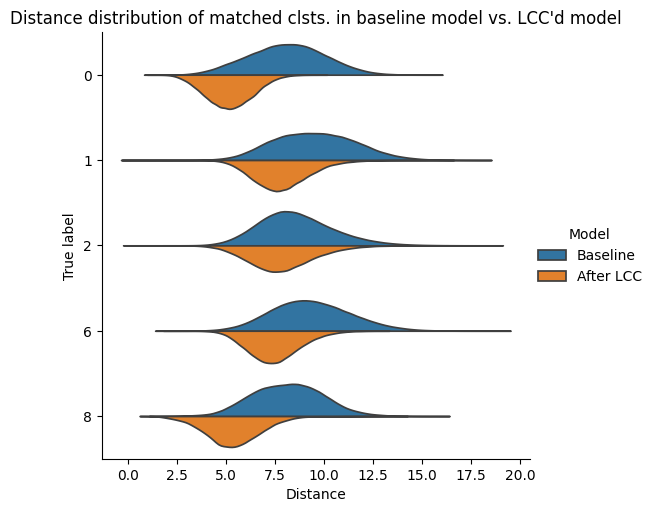

In [28]:
title = "Distance distribution of matched clsts. in baseline model vs. LCC'd model"

figure = sns.catplot(
    data=dd_df,
    x="Distance",
    y="True label",
    hue="Model",
    kind="violin",
    split=True,
    inner=None,
)
figure.set(title=title)
figure.savefig(OUTPUT_DIR / "dd.png")
figure